# [Kaggle: Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

if False:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:

            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TEST_DIR = "/kaggle/input/histopathologic-cancer-detection/test/"
TRAIN_DIR = "/kaggle/input/histopathologic-cancer-detection/train/"
LABELS_PATH = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skimage.io import imread

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1_l2


import matplotlib.pyplot as plt

2024-05-24 19:19:14.645537: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 19:19:14.645658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 19:19:14.797367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


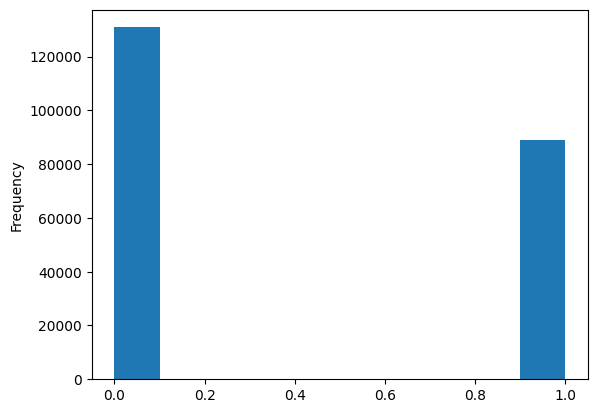

In [3]:
labels = pd.read_csv(LABELS_PATH)
labels['id'] = TRAIN_DIR + labels['id'] + '.tif'
labels['label'].plot.hist()
labels['label']  = labels['label'].apply(str)
# labels['label'] = labels['label'].apply(str)
labels = labels.loc[:1024]


In [4]:
# Define the image size and batch size
img_size = (96, 96)
batch_size = 16
kw = dict(
    dataframe=labels,
    directory='train',
    x_col='id',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)
augmentation = dict()
# augmentation = dict(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, **augmentation)
train_generator = train_datagen.flow_from_dataframe(subset='training', **kw)
test_generator = train_datagen.flow_from_dataframe(subset='validation', **kw)

Found 820 validated image filenames belonging to 2 classes.
Found 205 validated image filenames belonging to 2 classes.


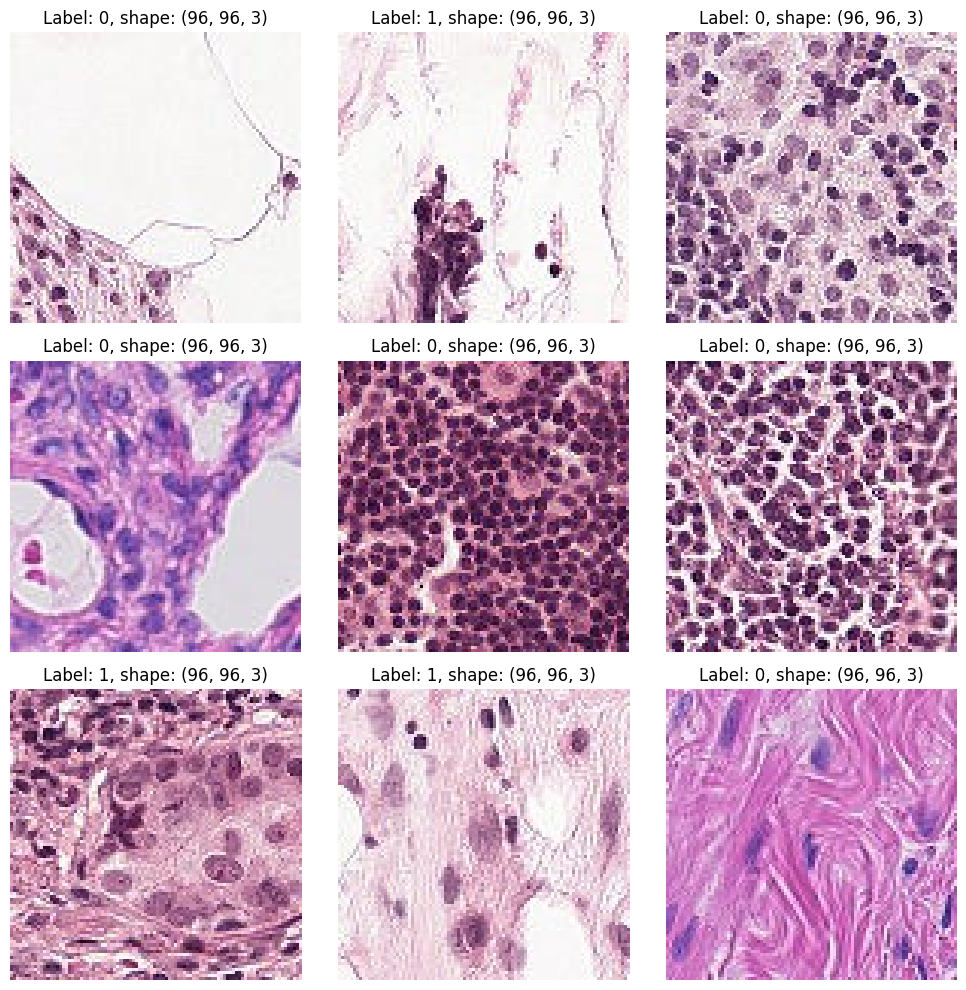

In [5]:
def show_images(read_image, read_label):
    # Get a batch of images and labels from the generator
    batch_size = 9

    # Create a grid of subplots
    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

    # Plot the images in the grid
    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]
        img = read_image(i)
        ax.imshow(img)
        ax.set_title(f"Label: {read_label(i)}, shape: {img.shape}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show some images by reading them
show_images(lambda i: imread(labels['id'][i]), lambda i: labels['label'][i])

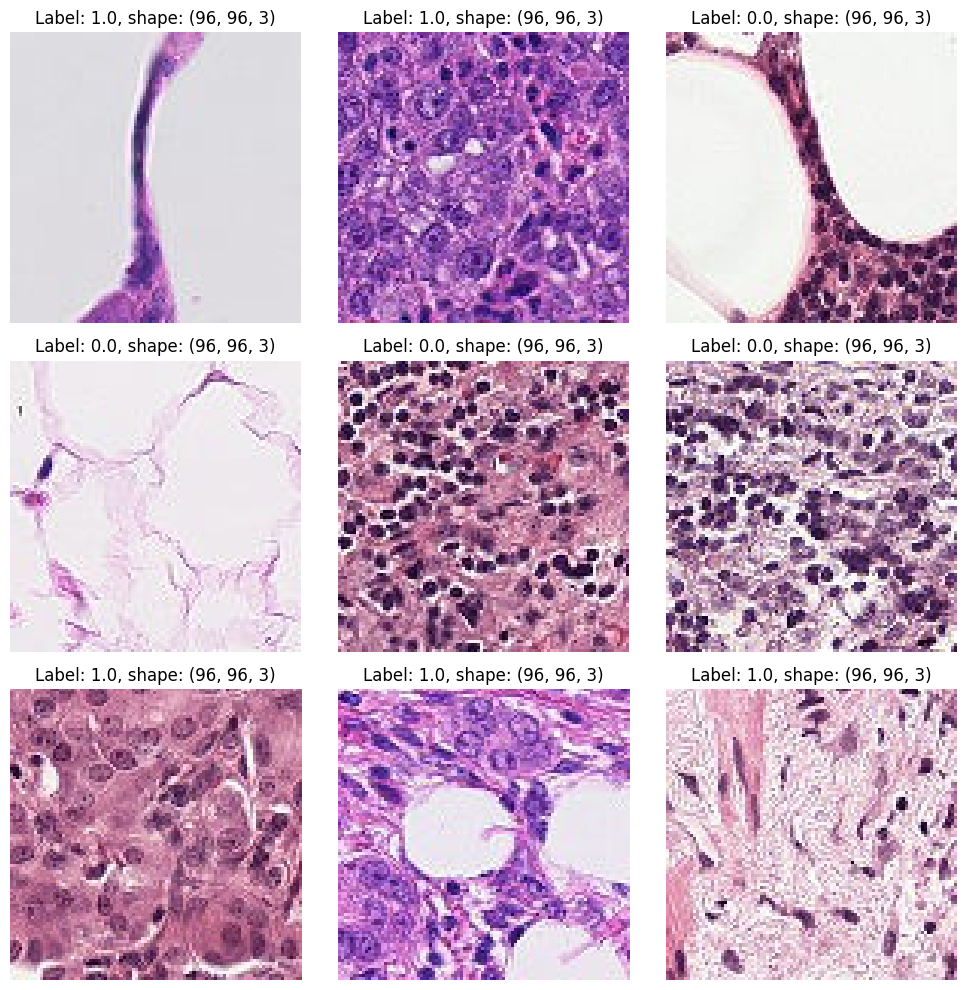

In [6]:
# Now vibe-check train_generator images 
batch = train_generator[10]
show_images(lambda i: batch[0][i], lambda i: batch[1][i])

In [7]:
# the model is just a standard convolution model
# Define the model architecture: We started with a convolutional NN
# Then we made it a bit bigger because it wouldn't fit the data
# BatchNormalization helped converge faster 
# Dropout was supposed to avoid overfitting but didn't do much
# the kernel_regularizer helps more with that
conv_block = lambda c: [
    Conv2D(c, (3, 3), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
]

lin_block = lambda c: [
    Dense(c, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.5),
]

model = Sequential([
    *conv_block(64),
    *conv_block(64),
    *conv_block(128),
    Flatten(),
    *lin_block(128),
    *lin_block(64),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [8]:
# Now train. The loss after 10 iterations is somehow worse than random
epochs = 20
model.fit(train_generator, epochs=epochs, validation_data=test_generator)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.6186 - loss: 155.1385 - val_accuracy: 0.4098 - val_loss: 50.9194
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.6477 - loss: 41.6873 - val_accuracy: 0.4098 - val_loss: 25.8843
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.6534 - loss: 21.6330 - val_accuracy: 0.4098 - val_loss: 15.2376
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.6782 - loss: 13.6365 - val_accuracy: 0.5902 - val_loss: 11.3025
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.6260 - loss: 10.3170 - val_accuracy: 0.4683 - val_loss: 9.4226
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 353ms/step - accuracy: 0.6585 - loss: 8.6096 - val_accuracy: 0.4098 - val_loss: 6.4377
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.6614 - loss: 5.9949 - val_accuracy: 0.5902 - val_loss: 4.8036
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.5962 - loss: 4.5340 - val_accur